In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

In [2]:
# Load dataset and inspect target distribution
path = Path("../../data/raw/online_shoppers_intention.csv")
df = pd.read_csv(path)
print(f"Loaded shape: {df.shape}")
print("Revenue distribution:\n", df['Revenue'].value_counts())

Loaded shape: (12330, 18)
Revenue distribution:
 Revenue
False    10422
True      1908
Name: count, dtype: int64


In [3]:
# Basic preprocessing: encode target and one-hot encode features
df['Revenue'] = df['Revenue'].astype(int)
X = df.drop('Revenue', axis=1)
y = df['Revenue']
cat_cols = X.select_dtypes(include=['object', 'bool']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"Categorical cols ({len(cat_cols)}): {cat_cols}")
print(f"Numeric cols ({len(num_cols)}): {num_cols}")
X_encoded = pd.get_dummies(X, drop_first=True)
print(f"Encoded feature matrix shape: {X_encoded.shape}")


Categorical cols (3): ['Month', 'VisitorType', 'Weekend']
Numeric cols (14): ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'OperatingSystems', 'Browser', 'Region', 'TrafficType']
Encoded feature matrix shape: (12330, 26)


In [4]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Train shape: (9864, 26), Test shape: (2466, 26)


In [5]:
# Feature scaling (StandardScaler)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled[:3], X_test_scaled[:3]  # sadece küçük kontrol


(array([[ 1.7120884 ,  3.62474482, -0.39578211, -0.24458924,  0.05840527,
          0.08339286, -0.3537925 , -0.61292345,  0.3410137 ,  3.66343985,
          0.9503449 ,  0.36544319, -0.06376855, -0.51585403, -0.5492383 ,
         -0.40517717, -0.12257107, -0.19009065, -0.1538222 , -0.42979362,
          1.62766046, -0.56080205, -0.2171031 , -0.19685822, -0.08694098,
          0.41025005],
        [-0.69829357, -0.45234111, -0.39578211, -0.24458924, -0.62945941,
         -0.539163  ,  0.36069829,  1.15926204, -0.3202677 , -0.31149918,
         -1.2281822 ,  3.2510753 , -0.06376855, -0.76491836,  1.82070333,
         -0.40517717, -0.12257107, -0.19009065, -0.1538222 , -0.42979362,
         -0.61437875, -0.56080205,  4.60610641, -0.19685822, -0.08694098,
          0.41025005],
        [-0.69829357, -0.45234111, -0.39578211, -0.24458924, -0.62945941,
         -0.59950381, -0.45886467,  0.13674565, -0.3202677 , -0.31149918,
         -0.13891865,  4.40532814, -0.89855681, -0.51585403, -0.54

Accuracy: 0.8812
Classification report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      2084
           1       0.74      0.36      0.48       382

    accuracy                           0.88      2466
   macro avg       0.82      0.67      0.71      2466
weighted avg       0.87      0.88      0.86      2466

Confusion matrix:
 [[2037   47]
 [ 246  136]]


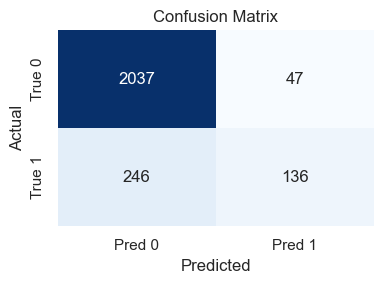

In [6]:
# Logistic Regression baseline model
model = LogisticRegression(max_iter=2000, C=1.0, n_jobs=-1, random_state=42)
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.4f}")
print("Classification report:\n" + classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['True 0', 'True 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


Balanced LogisticRegression - Accuracy: 0.8500
Balanced LogisticRegression - ROC-AUC: 0.8963
Classification report (balanced):
               precision    recall  f1-score   support

           0       0.95      0.87      0.91      2084
           1       0.51      0.75      0.61       382

    accuracy                           0.85      2466
   macro avg       0.73      0.81      0.76      2466
weighted avg       0.88      0.85      0.86      2466

Confusion matrix (balanced):
 [[1810  274]
 [  96  286]]


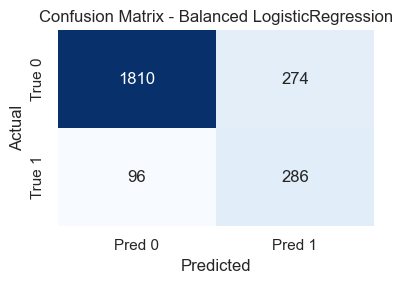

In [7]:
# Improved Logistic Regression with class_weight='balanced'

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Bu model, sınıf dengesizliğini hesaba katıyor
log_reg_balanced = LogisticRegression(
    max_iter=2000,
    C=1.0,
    class_weight="balanced",   # <<< ÖNEMLİ: az olan sınıfa daha fazla ağırlık ver
    solver="liblinear",        # dengesiz sınıflarda genelde iyi çalışıyor
    random_state=42
)

# X_train_scaled ve X_test_scaled zaten üst hücrelerde tanımlanmış olmalı
log_reg_balanced.fit(X_train_scaled, y_train)

# Tahminler
y_pred_bal = log_reg_balanced.predict(X_test_scaled)
y_proba_bal = log_reg_balanced.predict_proba(X_test_scaled)[:, 1]

# Metrikler
acc_bal = accuracy_score(y_test, y_pred_bal)
roc_bal = roc_auc_score(y_test, y_proba_bal)

print(f"Balanced LogisticRegression - Accuracy: {acc_bal:.4f}")
print(f"Balanced LogisticRegression - ROC-AUC: {roc_bal:.4f}")
print("Classification report (balanced):\n", classification_report(y_test, y_pred_bal))

# Confusion matrix
cm_bal = confusion_matrix(y_test, y_pred_bal)
print("Confusion matrix (balanced):\n", cm_bal)

plt.figure(figsize=(4, 3))
sns.heatmap(
    cm_bal,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['Pred 0', 'Pred 1'],
    yticklabels=['True 0', 'True 1']
)
plt.title('Confusion Matrix - Balanced LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()


# Baseline Model Bulguları

Baseline olarak Logistic Regression modeli kullanıldı. Scaling sonrası elde edilen sonuçlar:

- Accuracy ≈ 0.88
- Revenue=1 sınıfında:
  - Recall düşüktü (≈ 0.36)
  - F1-score düşüktü (≈ 0.48)

Bu nedenle model çoğunluk sınıfa ağırlık verdi ve azınlık sınıfı yakalamakta zorlandı.  
class_weight='balanced' kullanılarak yapılan iyileştirme sonucunda:

- Recall 0.36 → 0.75'e yükseldi
- F1-score 0.48 → 0.61'e yükseldi
- Model Revenue=1 sınıfını çok daha başarılı şekilde yakalamaya başladı.

Bu nedenle baseline sonrası iyileştirilmiş Logistic Regression modeli referans olarak alınmıştır.
